# Trafic Light Classifier Carla

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Import Images from Data/Carla...

In [2]:
X_train = []
x_label = []
for img_class, directory in enumerate(['data/carla_red', 'data/carla_yellow', 'data/carla_green', 'data/carla_none']):
    for i, file_name in enumerate(glob.glob("{}/*.jpg".format(directory))):
        file = cv2.imread(file_name)
        file = cv2.cvtColor(file, cv2.COLOR_BGR2RGB);
        resized = cv2.resize(file, (32,64))
        
        X_train.append(resized/255.)
        x_label.append(img_class)
print('checking datasets and labels')       
X_train = np.array(X_train)
x_label = np.array(x_label)

checking datasets and labels


In [3]:
print(X_train)

[[[[0.52156863 0.51372549 0.51764706]
   [0.48627451 0.47843137 0.47843137]
   [0.45882353 0.45098039 0.45490196]
   ...
   [0.43921569 0.43137255 0.45490196]
   [0.44313725 0.44313725 0.46666667]
   [0.44313725 0.44313725 0.47058824]]

  [[0.4745098  0.46666667 0.47058824]
   [0.46666667 0.45882353 0.4627451 ]
   [0.44313725 0.43529412 0.43921569]
   ...
   [0.43921569 0.43137255 0.45490196]
   [0.44313725 0.43921569 0.4627451 ]
   [0.44313725 0.44705882 0.4745098 ]]

  [[0.44705882 0.43921569 0.44313725]
   [0.43921569 0.43529412 0.43921569]
   [0.43137255 0.42352941 0.43137255]
   ...
   [0.43921569 0.42745098 0.45098039]
   [0.43921569 0.43529412 0.45882353]
   [0.44705882 0.44313725 0.47058824]]

  ...

  [[0.5254902  0.50980392 0.51372549]
   [0.52156863 0.50196078 0.50588235]
   [0.51372549 0.48235294 0.49019608]
   ...
   [0.45098039 0.43921569 0.46666667]
   [0.45098039 0.44313725 0.46666667]
   [0.47058824 0.45490196 0.4745098 ]]

  [[0.50196078 0.48627451 0.49019608]
   [0.5

In [4]:
x_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

## 2. Build CNN

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.utils.np_utils import to_categorical
from keras import losses, optimizers, regularizers

In [26]:
categorical_labels = to_categorical(x_label) # https://keras.io/utils/#to_categorical
num_classes = 4 # red, yellow, green, none
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64, 32, 3), padding='same', activation='relu', kernel_initializer='random_uniform', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))
Dropout(0.2)
model.add(Flatten())
model.add(Dense(8, activation='relu', kernel_initializer='random_uniform', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(num_classes, activation='softmax'))
loss = losses.categorical_crossentropy
optimizer = optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 131080    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
Total params: 132,012
Trainable params: 132,012
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train, categorical_labels, batch_size=256, epochs=30, verbose=True, validation_split=0.1, shuffle=True)

Train on 407 samples, validate on 46 samples
Epoch 1/30
407/407 [==============================] - 1s 2ms/step - loss: 0.6244 - acc: 0.8378 - val_loss: 1.3714 - val_acc: 0.5652
Epoch 2/30
407/407 [==============================] - 1s 2ms/step - loss: 0.6157 - acc: 0.8477 - val_loss: 1.0215 - val_acc: 0.8261
Epoch 3/30
407/407 [==============================] - 1s 2ms/step - loss: 0.6171 - acc: 0.8698 - val_loss: 1.5783 - val_acc: 0.5217
Epoch 4/30
407/407 [==============================] - 1s 2ms/step - loss: 0.5819 - acc: 0.8550 - val_loss: 2.2660 - val_acc: 0.1522
Epoch 5/30
407/407 [==============================] - 1s 2ms/step - loss: 0.6022 - acc: 0.8501 - val_loss: 2.0228 - val_acc: 0.1957
Epoch 6/30
407/407 [==============================] - 1s 2ms/step - loss: 0.5708 - acc: 0.8649 - val_loss: 1.3998 - val_acc: 0.7609
Epoch 7/30
407/407 [==============================] - 1s 2ms/step - loss: 0.5738 - acc: 0.8796 - val_loss: 1.2297 - val_acc: 0.8043
Epoch 8/30
407/407 [===========

In [18]:
score = model.evaluate(X_train, categorical_labels, verbose=True)
print(score)

453/453 [==============================] - 0s 803us/step
[0.5635325882345372, 0.8984547462026541]


In [19]:
prediction = model.predict(X_train, verbose=1)
for i in range(len(prediction)):
    print (i, prediction[i], categorical_labels[i])

453/453 [==============================] - 0s 760us/step
(0, array([0.15555003, 0.37152064, 0.26204786, 0.2108815 ], dtype=float32), array([1., 0., 0., 0.]))
(1, array([0.50708675, 0.00803134, 0.05918702, 0.42569488], dtype=float32), array([1., 0., 0., 0.]))
(2, array([0.85488826, 0.05095629, 0.048654  , 0.04550149], dtype=float32), array([1., 0., 0., 0.]))
(3, array([0.9829426 , 0.00643945, 0.00160871, 0.00900931], dtype=float32), array([1., 0., 0., 0.]))
(4, array([0.57960093, 0.10753837, 0.2122458 , 0.1006149 ], dtype=float32), array([1., 0., 0., 0.]))
(5, array([0.976393  , 0.02022736, 0.00127139, 0.00210831], dtype=float32), array([1., 0., 0., 0.]))
(6, array([0.8810818 , 0.01232727, 0.00604515, 0.10054572], dtype=float32), array([1., 0., 0., 0.]))
(7, array([9.9584264e-01, 3.4156044e-03, 2.3327465e-04, 5.0850800e-04],
      dtype=float32), array([1., 0., 0., 0.]))
(8, array([0.86605316, 0.0244396 , 0.04547979, 0.06402758], dtype=float32), array([1., 0., 0., 0.]))
(9, array([0.749

      dtype=float32), array([1., 0., 0., 0.]))
(109, array([0.9711211 , 0.01886548, 0.00901225, 0.00100127], dtype=float32), array([1., 0., 0., 0.]))
(110, array([9.7170389e-01, 2.6951468e-02, 9.8901428e-04, 3.5565658e-04],
      dtype=float32), array([1., 0., 0., 0.]))
(111, array([9.8185158e-01, 1.2107494e-02, 5.7435092e-03, 2.9737584e-04],
      dtype=float32), array([1., 0., 0., 0.]))
(112, array([0.914513  , 0.0192351 , 0.03810631, 0.02814557], dtype=float32), array([1., 0., 0., 0.]))
(113, array([0.84997576, 0.05178634, 0.04156898, 0.05666891], dtype=float32), array([1., 0., 0., 0.]))
(114, array([0.8877936 , 0.01416519, 0.02299983, 0.07504147], dtype=float32), array([1., 0., 0., 0.]))
(115, array([0.6022936 , 0.03119818, 0.23371182, 0.13279644], dtype=float32), array([1., 0., 0., 0.]))
(116, array([0.6898853 , 0.0205272 , 0.18819594, 0.10139153], dtype=float32), array([1., 0., 0., 0.]))
(117, array([0.9672773 , 0.00869737, 0.00137891, 0.02264647], dtype=float32), array([1., 0., 

(224, array([2.5376761e-03, 7.2296833e-05, 9.9556077e-01, 1.8291589e-03],
      dtype=float32), array([0., 0., 1., 0.]))
(225, array([0.09563307, 0.00476578, 0.73213077, 0.16747032], dtype=float32), array([0., 0., 1., 0.]))
(226, array([0.06409458, 0.00095869, 0.9279101 , 0.00703659], dtype=float32), array([0., 0., 1., 0.]))
(227, array([0.02000858, 0.1771983 , 0.7726414 , 0.03015175], dtype=float32), array([0., 0., 1., 0.]))
(228, array([0.01277017, 0.00841491, 0.9286981 , 0.05011673], dtype=float32), array([0., 0., 1., 0.]))
(229, array([2.6775964e-03, 1.8814816e-04, 9.5666009e-01, 4.0474076e-02],
      dtype=float32), array([0., 0., 1., 0.]))
(230, array([0.06849578, 0.00292576, 0.8512662 , 0.07731225], dtype=float32), array([0., 0., 1., 0.]))
(231, array([8.8583007e-03, 2.5241324e-04, 9.8652840e-01, 4.3608132e-03],
      dtype=float32), array([0., 0., 1., 0.]))
(232, array([1.4287559e-06, 1.4642757e-07, 9.9980873e-01, 1.8972780e-04],
      dtype=float32), array([0., 0., 1., 0.]))
(

(349, array([0.00114643, 0.0053237 , 0.03256737, 0.96096253], dtype=float32), array([0., 0., 0., 1.]))
(350, array([2.3918655e-03, 5.0772418e-04, 7.8865695e-01, 2.0844343e-01],
      dtype=float32), array([0., 0., 0., 1.]))
(351, array([7.2241803e-03, 5.9541620e-05, 1.3553590e-01, 8.5718036e-01],
      dtype=float32), array([0., 0., 0., 1.]))
(352, array([0.2792776 , 0.0579764 , 0.27967712, 0.3830689 ], dtype=float32), array([0., 0., 0., 1.]))
(353, array([6.9027531e-01, 1.2274942e-04, 7.5328969e-03, 3.0206898e-01],
      dtype=float32), array([0., 0., 0., 1.]))
(354, array([0.397198  , 0.19331668, 0.00564318, 0.40384212], dtype=float32), array([0., 0., 0., 1.]))
(355, array([0.4841674 , 0.07178759, 0.04568749, 0.39835754], dtype=float32), array([0., 0., 0., 1.]))
(356, array([0.14290155, 0.0465056 , 0.34988037, 0.46071243], dtype=float32), array([0., 0., 0., 1.]))
(357, array([0.28542274, 0.05175112, 0.2321699 , 0.43065622], dtype=float32), array([0., 0., 0., 1.]))
(358, array([0.0444

(426, array([0.6490681 , 0.06342112, 0.14997332, 0.13753745], dtype=float32), array([0., 0., 0., 1.]))
(427, array([0.3484658 , 0.05791762, 0.01096931, 0.58264726], dtype=float32), array([0., 0., 0., 1.]))
(428, array([0.27756104, 0.03766554, 0.3222929 , 0.36248046], dtype=float32), array([0., 0., 0., 1.]))
(429, array([0.2667266 , 0.05153162, 0.23996548, 0.44177634], dtype=float32), array([0., 0., 0., 1.]))
(430, array([0.86069614, 0.00280404, 0.10015392, 0.03634585], dtype=float32), array([0., 0., 0., 1.]))
(431, array([5.2122945e-05, 3.8214781e-05, 8.7860107e-01, 1.2130853e-01],
      dtype=float32), array([0., 0., 0., 1.]))
(432, array([0.17058654, 0.02606551, 0.3796865 , 0.4236614 ], dtype=float32), array([0., 0., 0., 1.]))
(433, array([0.7925088 , 0.01170825, 0.01325242, 0.18253064], dtype=float32), array([0., 0., 0., 1.]))
(434, array([0.21176091, 0.03464552, 0.2960125 , 0.45758113], dtype=float32), array([0., 0., 0., 1.]))
(435, array([0.13391858, 0.522662  , 0.03603593, 0.3073

In [20]:
%matplotlib inline
fig = plt.figure()
import operator

LABELS = list(enumerate(['Red', 'Yellow', 'Green', 'None']))

def read_prediction(predictions):
    index, value = max(enumerate(predictions), key=operator.itemgetter(1))
    print('Max prediction score', value)
    print('Predicted label: ', LABELS[index][1])
    
def read_label(example_image_id):
    print(prediction[example_image_id])
    print('Ground truth label: ', print_label(categorical_labels[example_image_id]))
    read_prediction(prediction[example_image_id])
    plt.imshow(X_train[example_image_id])  
    
def print_label(categorical_label):
    color = ''
    for i in range(categorical_label.shape[0]):
        if categorical_label[i] == 1.0:           
            color = LABELS[i][1]
            if color != '': return color
        else:
            color = 'None'
    return color    

In [21]:
import h5py # needed for model saving
model.save('tl_classifier_carla.h5')

[0.9734117  0.00309881 0.00270285 0.02078664]
('Ground truth label: ', 'Red')
('Max prediction score', 0.9734117)
('Predicted label: ', 'Red')


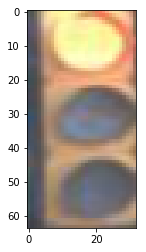

In [22]:
read_label(46)  

[0.02449352 0.9194063  0.05178409 0.00431611]
('Ground truth label: ', 'Yellow')
('Max prediction score', 0.9194063)
('Predicted label: ', 'Yellow')


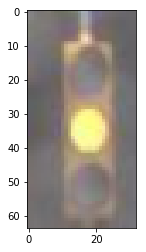

In [23]:
read_label(172)  

[0.02158384 0.03724946 0.88566905 0.05549772]
('Ground truth label: ', 'Green')
('Max prediction score', 0.88566905)
('Predicted label: ', 'Green')


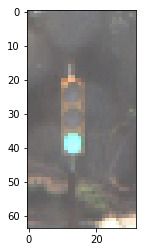

In [24]:
read_label(216)  

[0.15748739 0.02413439 0.12998444 0.68839383]
('Ground truth label: ', 'None')
('Max prediction score', 0.68839383)
('Predicted label: ', 'None')


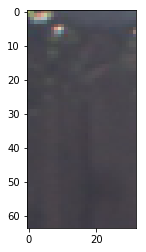

In [25]:
read_label(400)